In [10]:
import nrrd
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from skimage.segmentation import mark_boundaries
import cv2
import argparse
from numba import jit
from scipy import ndimage as ndi

mask_path = "/Users/jamesdarby/Documents/VesuviusScroll/GP/EmbedSegScrolls/manually_labelled_cubes/test/instances/layers_1.nrrd"
raw_data_path = "/Users/jamesdarby/Documents/VesuviusScroll/GP/EmbedSegScrolls/manually_labelled_cubes/test/volumes/slices_1.nrrd"

mask_data, mask_header = nrrd.read(mask_path)
raw_data, raw_header = nrrd.read(raw_data_path)

In [2]:
#helper functions: TODO move to separate file
import numpy as np
from skimage.color import gray2rgb, label2rgb
from skimage.segmentation import find_boundaries
from skimage.util import img_as_float
from skimage.morphology import dilation, square
import random

def mark_boundaries_color(image, label_img, color=None, outline_color=None, mode='outer', background_label=0, dilation_size=1):
    """Return image with boundaries between labeled regions highlighted with consistent colors derived from labels.

    Parameters:
    - image: Input image.
    - label_img: Image with labeled regions.
    - color: Ignored in this version.
    - outline_color: If specified, use this color for the outline. Otherwise, use the same as boundary.
    - mode: Choose 'inner', 'outer', or 'thick' to define boundary type.
    - background_label: Label to be treated as the background.
    - dilation_size: Size of the dilation square for the boundaries.

    Returns:
    - Image with boundaries highlighted.
    """
    # Ensure input image is in float and has three channels
    float_dtype = np.float32  # Use float32 for efficiency
    marked = img_as_float(image, force_copy=True).astype(float_dtype, copy=False)
    if marked.ndim == 2:
        marked = gray2rgb(marked)

    # Create a color map normalized by the number of unique labels
    unique_labels = np.unique(label_img)
    color_map = plt.get_cmap('nipy_spectral')  # You can change 'nipy_spectral' to any other colormap

    # Find boundaries and apply colors
    boundaries = find_boundaries(label_img, mode=mode, background=background_label)
    for label in unique_labels:
        if label == background_label:
            continue
        # Normalize label value to the range of the colormap
        normalized_color = color_map(label / np.max(unique_labels))[:3]  # Get RGB values only
        label_boundaries = find_boundaries(label_img == label, mode=mode)
        label_boundaries = dilation(label_boundaries, square(dilation_size))
        marked[label_boundaries] = normalized_color
        if outline_color is not None:
            outlines = dilation(label_boundaries, square(dilation_size + 1))
            marked[outlines] = outline_color
        else:
            marked[label_boundaries] = normalized_color

    return marked

def mark_boundaries_multicolor(image, label_img, color=None, outline_color=None, mode='outer', background_label=0, dilation_size=1):
    """Return image with boundaries between labeled regions highlighted with consistent colors.

    Parameters are the same as in the original function but color is ignored if provided.
    """
    # Ensure input image is in float and has three channels
    float_dtype = np.float32  # Use float32 for efficiency
    marked = img_as_float(image, force_copy=True).astype(float_dtype, copy=False)
    if marked.ndim == 2:
        marked = gray2rgb(marked)

    # Generate consistent colors for each unique label in label_img
    unique_labels = np.unique(label_img)
    color_map = {label: consistent_color(label) for label in unique_labels if label != background_label}

    # Find boundaries and apply colors
    boundaries = find_boundaries(label_img, mode=mode, background=background_label)
    for label, color in color_map.items():
        label_boundaries = find_boundaries(label_img == label, mode=mode)
        label_boundaries = dilation(label_boundaries, square(dilation_size))
        if outline_color is not None:
            outlines = dilation(label_boundaries, square(dilation_size))
            marked[outlines] = outline_color
        marked[label_boundaries] = color

    return marked


In [3]:
def plot_slice(slice_index, axis=0):
    plt.figure(figsize=(8, 6))
    if axis == 1:
        plt.imshow(mark_boundaries_color(raw_data[:,slice_index,:], mask_data[:,slice_index,:]))
    elif axis == 2:
        plt.imshow(mark_boundaries_color(raw_data[:,:,slice_index], mask_data[:,:,slice_index]))
    else:
        plt.imshow(mark_boundaries_color(raw_data[slice_index,:,:], mask_data[slice_index,:,:]))
    plt.colorbar()
    plt.title(f'Slice {slice_index}')
    plt.show()

# Create a slider to browse through slices
interact(plot_slice, slice_index=IntSlider(min=0, max=mask_data.shape[0]-1, step=1, value=0), axis=IntSlider(min=0, max=2, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=255), IntSlider(value=0, description='…

<function __main__.plot_slice(slice_index, axis=0)>

In [ ]:
import networkx as nx
G = nx.Graph()

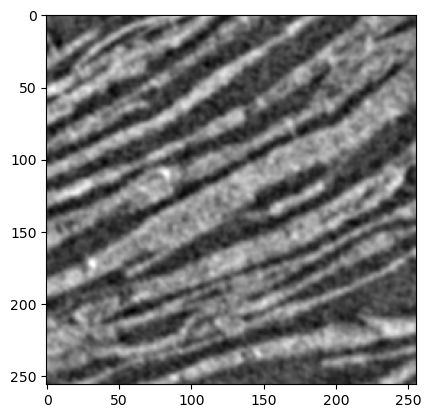

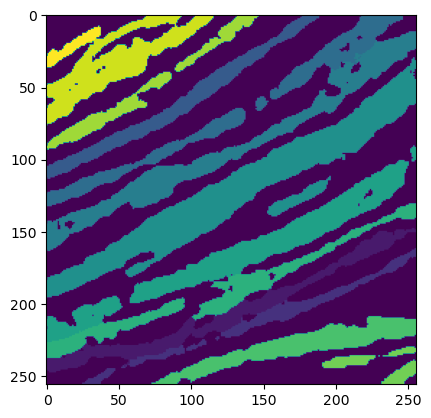

In [4]:
test_slice = raw_data[0,:,:]
test_mask = mask_data[0,:,:]
plt.imshow(test_slice, cmap='gray')
plt.show()
plt.imshow(test_mask)
plt.show()

In [11]:
from numba import jit, prange

@jit(nopython=True, parallel=True)
def create_graph_parallel(test_mask):
    z, y, x = test_mask.shape
    
    # Creating an array to store edge weights
    edge_weights = np.zeros((z, y, x, 6))  # six possible edges for each voxel

    # Parallelize the outer loop
    for i in prange(z):
        for j in range(y):
            for k in range(x):
                # Check each of the six possible neighbors
                # Neighbor 1: (i+1, j, k) - down
                if i < z - 1:
                    edge_weights[i, j, k, 0] = 10 if test_mask[i, j, k] != 0 and test_mask[i+1, j, k] != 0 else 1
                # Neighbor 2: (i-1, j, k) - up
                if i > 0:
                    edge_weights[i, j, k, 1] = 10 if test_mask[i, j, k] != 0 and test_mask[i-1, j, k] != 0 else 1
                # Neighbor 3: (i, j+1, k) - right
                if j < y - 1:
                    edge_weights[i, j, k, 2] = 10 if test_mask[i, j, k] != 0 and test_mask[i, j+1, k] != 0 else 1
                # Neighbor 4: (i, j-1, k) - left
                if j > 0:
                    edge_weights[i, j, k, 3] = 10 if test_mask[i, j, k] != 0 and test_mask[i, j-1, k] != 0 else 1
                # Neighbor 5: (i, j, k+1) - forward
                if k < x - 1:
                    edge_weights[i, j, k, 4] = 10 if test_mask[i, j, k] != 0 and test_mask[i, j, k+1] != 0 else 1
                # Neighbor 6: (i, j, k-1) - backward
                if k > 0:
                    edge_weights[i, j, k, 5] = 10 if test_mask[i, j, k] != 0 and test_mask[i, j, k-1] != 0 else 1
    
    return edge_weights

graph_rep = create_graph_parallel(mask_data)
print(graph_rep.shape)
print(graph_rep[0,0,0])

(256, 256, 256, 6)
[1. 0. 1. 0. 1. 0.]


In [13]:
import networkx as nx

#took ~90 seconds to run on 256^3 cube + 6 edges per voxel
def create_networkx_graph(edge_weights):
    z, y, x, _ = edge_weights.shape
    G = nx.Graph()

    # Iterate over each voxel and add edges to the graph
    for i in range(z):
        for j in range(y):
            for k in range(x):
                current_index = i * y * x + j * x + k
                # Down
                if i < z - 1:
                    G.add_edge(current_index, current_index + y * x, capacity=edge_weights[i, j, k, 0])
                # Up
                if i > 0:
                    G.add_edge(current_index, current_index - y * x, capacity=edge_weights[i, j, k, 1])
                # Right
                if j < y - 1:
                    G.add_edge(current_index, current_index + x, capacity=edge_weights[i, j, k, 2])
                # Left
                if j > 0:
                    G.add_edge(current_index, current_index - x, capacity=edge_weights[i, j, k, 3])
                # Forward
                if k < x - 1:
                    G.add_edge(current_index, current_index + 1, capacity=edge_weights[i, j, k, 4])
                # Backward
                if k > 0:
                    G.add_edge(current_index, current_index - 1, capacity=edge_weights[i, j, k, 5])

    return G

G = create_networkx_graph(graph_rep)

In [15]:
def add_source_sink_to_graph(G, z, y, x, source_face, sink_face, large_weight=float('inf')):
    # Define source and sink node labels
    source_node = 'source'
    sink_node = 'sink'
    
    # Add source and sink nodes to the graph
    G.add_node(source_node)
    G.add_node(sink_node)
    
    # Helper function to generate node indices for a specific face
    def get_face_indices(face):
        if face == 'left':
            return [(i, j, 0) for i in range(z) for j in range(y)]
        elif face == 'right':
            return [(i, j, x-1) for i in range(z) for j in range(y)]
        elif face == 'top':
            return [(0, j, k) for j in range(y) for k in range(x)]
        elif face == 'bottom':
            return [(z-1, j, k) for j in range(y) for k in range(x)]
        elif face == 'front':
            return [(i, 0, k) for i in range(z) for k in range(x)]
        elif face == 'back':
            return [(i, y-1, k) for i in range(z) for k in range(x)]
        else:
            return []

    # Connect source and sink nodes to their respective faces
    source_indices = get_face_indices(source_face)
    sink_indices = get_face_indices(sink_face)

    for idx in source_indices:
        G.add_edge(source_node, idx, capacity=large_weight)
    for idx in sink_indices:
        G.add_edge(idx, sink_node, capacity=large_weight)
    
    return G, source_node, sink_node

Gs, source, sink = add_source_sink_to_graph(G, 256,256,256, 'left', 'right')

In [16]:
#3m 36s to calculate min cut, way too slow as this operation will need to be repeated many times
cut_val, partition = nx.minimum_cut(Gs, source, sink)
print(cut_val)

0


In [ ]:
print(len(partition[0]), len(partition[1]))

In [9]:
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import maximum_flow

def create_sparse_graph_from_numpy(edge_weights, test_mask):
    z, y, x, _ = edge_weights.shape
    num_voxels = z * y * x
    graph = lil_matrix((num_voxels + 2, num_voxels + 2))  # +2 for source and sink nodes

    source_node = num_voxels
    sink_node = num_voxels + 1
    infinite_weight = float('inf')

    # Map 3D indices to 1D and connect graph edges based on edge_weights
    for i in range(z):
        for j in range(y):
            for k in range(x):
                node_index = i * y * x + j * x + k

                # Connect to adjacent nodes if there's an edge weight
                if k < x - 1:  # forward in k direction
                    graph[node_index, node_index + 1] = edge_weights[i, j, k, 4]
                if j < y - 1:  # forward in j direction
                    graph[node_index, node_index + x] = edge_weights[i, j, k, 2]
                if i < z - 1:  # forward in i direction
                    graph[node_index, node_index + (y * x)] = edge_weights[i, j, k, 0]

                # Connect all left-side nodes to the source, and right-side nodes to the sink
                if k == 0:
                    graph[source_node, node_index] = infinite_weight
                if k == x - 1:
                    graph[node_index, sink_node] = infinite_weight

    return csr_matrix(graph)  # Convert to CSR for efficient computation

def find_min_cut_from_numpy(graph):
    cut_value, partition = maximum_flow(graph, 0, graph.shape[0] - 1)
    return cut_value, partition

# Example usage:
z, y, x = 10, 10, 10
edge_weights = np.zeros((z, y, x, 6))  # Simulated edge weights
# Assuming test_mask is defined if you want to use it for setting edge_weights conditions

# Example setting some edge weights for illustration
for i in range(z):
    for j in range(y):
        for k in range(x-1):
            edge_weights[i, j, k, 4] = 10  # Example weight for demonstration

graph = create_sparse_graph_from_numpy(edge_weights, test_mask=None)  # test_mask can be used if needed
cut_value, partition = find_min_cut_from_numpy(graph)
print("Min-Cut Value:", cut_value)

ValueError: graph capacities must be integers

In [36]:
import networkx as nx
def create_and_find_min_cut(test_mask):
    z, y, x = test_mask.shape
    G = nx.Graph()

    # Create source and sink nodes
    source = 'source'
    sink = 'sink'
    infinite_weight = float('inf')

    # Connect source to all voxels on the left side and sink to all voxels on the right side
    for i in range(z):
        for j in range(y):
            # Source connection (left side)
            G.add_edge(source, (i, j, 0), capacity=infinite_weight)
            # Sink connection (right side)
            G.add_edge((i, j, x-1), sink, capacity=infinite_weight)

    # Connect adjacent voxels with given weights
    for i in range(z):
        for j in range(y):
            for k in range(x):
                # Connect to (i+1, j, k)
                if i < z - 1:
                    weight = 10 if test_mask[i, j, k] != 0 and test_mask[i+1, j, k] != 0 else 0
                    G.add_edge((i, j, k), (i+1, j, k), capacity=weight)
                # Connect to (i, j+1, k)
                if j < y - 1:
                    weight = 10 if test_mask[i, j, k] != 0 and test_mask[i, j+1, k] != 0 else 0
                    G.add_edge((i, j, k), (i, j+1, k), capacity=weight)
                # Connect to (i, j, k+1)
                if k < x - 1:
                    weight = 10 if test_mask[i, j, k] != 0 and test_mask[i, j, k+1] != 0 else 0
                    G.add_edge((i, j, k), (i, j, k+1), capacity=weight)

    # Compute the minimum cut
    cut_value, partition = nx.minimum_cut(G, source, sink)
    reachable, non_reachable = partition

    # Convert sets to lists of coordinates for easier handling
    reachable_voxels = list(filter(lambda v: v != source and v != sink and isinstance(v, tuple), reachable))
    non_reachable_voxels = list(filter(lambda v: v != source and v != sink and isinstance(v, tuple), non_reachable))

    return cut_value, reachable_voxels, non_reachable_voxels
cut_value, reachable_voxels, non_reachable_voxels = create_and_find_min_cut(mask_data)
print("Cut value:", cut_value)
print("Reachable from source (sample):", reachable[:10])  # Show a sample
print("Not reachable from sink (sample):", non_reachable[:10])  # Show a sample

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105c15450>>
Traceback (most recent call last):
  File "/Users/jamesdarby/anaconda3/envs/embedSegPy11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [25]:
SEAM_COLOR = np.array([255, 200, 200])    # seam visualization color (BGR)
SHOULD_DOWNSIZE = False                    # if True, downsize image for faster carving
DOWNSIZE_WIDTH = 500                      # resized image width if SHOULD_DOWNSIZE is True
ENERGY_MASK_CONST = 100000.0              # large energy value for protective masking
MASK_THRESHOLD = 10                       # minimum pixel intensity for binary mask
USE_FORWARD_ENERGY = True                 # if True, use forward energy algorithm

In [26]:
# 2D Utilitiy functions
def visualize(im, boolmask=None, rotate=False):
    vis = im.astype(np.uint8)
    if boolmask is not None:
        vis[np.where(boolmask == False)] = SEAM_COLOR
    if rotate:
        vis = rotate_image(vis, False)
    cv2.imshow("visualization", vis)
    cv2.waitKey(1)
    return vis

def resize(image, width):
    dim = None
    h, w = image.shape[:2]
    dim = (width, int(h * width / float(w)))
    return cv2.resize(image, dim)

def rotate_image(image, clockwise):
    k = 1 if clockwise else 3
    return np.rot90(image, k)    


In [27]:
# Energy functions
def backward_energy(im):
    """
    Simple gradient magnitude energy map.
    """
    xgrad = ndi.convolve1d(im, np.array([1, 0, -1]), axis=1, mode='wrap')
    ygrad = ndi.convolve1d(im, np.array([1, 0, -1]), axis=0, mode='wrap')
    
    grad_mag = np.sqrt(np.sum(xgrad**2, axis=2) + np.sum(ygrad**2, axis=2))

    # vis = visualize(grad_mag)
    # cv2.imwrite("backward_energy_demo.jpg", vis)

    return grad_mag

@jit
def forward_energy(im):
    """
    Forward energy algorithm as described in "Improved Seam Carving for Video Retargeting"
    by Rubinstein, Shamir, Avidan.

    Vectorized code adapted from
    https://github.com/axu2/improved-seam-carving.
    """
    h, w = im.shape[:2]
    im = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64)

    energy = np.zeros((h, w))
    m = np.zeros((h, w))
    
    U = np.roll(im, 1, axis=0)
    L = np.roll(im, 1, axis=1)
    R = np.roll(im, -1, axis=1)
    
    cU = np.abs(R - L)
    cL = np.abs(U - L) + cU
    cR = np.abs(U - R) + cU
    
    for i in range(1, h):
        mU = m[i-1]
        mL = np.roll(mU, 1)
        mR = np.roll(mU, -1)
        
        mULR = np.array([mU, mL, mR])
        cULR = np.array([cU[i], cL[i], cR[i]])
        mULR += cULR

        argmins = np.argmin(mULR, axis=0)
        m[i] = np.choose(argmins, mULR)
        energy[i] = np.choose(argmins, cULR)
    
    # vis = visualize(energy)
    # cv2.imwrite("forward_energy_demo.jpg", vis)     
        
    return energy

In [28]:
# Seam functions
@jit
def add_seam(im, seam_idx):
    """
    Add a vertical seam to a 3-channel color image at the indices provided 
    by averaging the pixels values to the left and right of the seam.

    Code adapted from https://github.com/vivianhylee/seam-carving.
    """
    h, w = im.shape[:2]
    output = np.zeros((h, w + 1, 3))
    for row in range(h):
        col = seam_idx[row]
        for ch in range(3):
            if col == 0:
                p = np.average(im[row, col: col + 2, ch])
                output[row, col, ch] = im[row, col, ch]
                output[row, col + 1, ch] = p
                output[row, col + 1:, ch] = im[row, col:, ch]
            else:
                p = np.average(im[row, col - 1: col + 1, ch])
                output[row, : col, ch] = im[row, : col, ch]
                output[row, col, ch] = p
                output[row, col + 1:, ch] = im[row, col:, ch]

    return output

@jit
def add_seam_grayscale(im, seam_idx):
    """
    Add a vertical seam to a grayscale image at the indices provided 
    by averaging the pixels values to the left and right of the seam.
    """    
    h, w = im.shape[:2]
    output = np.zeros((h, w + 1))
    for row in range(h):
        col = seam_idx[row]
        if col == 0:
            p = np.average(im[row, col: col + 2])
            output[row, col] = im[row, col]
            output[row, col + 1] = p
            output[row, col + 1:] = im[row, col:]
        else:
            p = np.average(im[row, col - 1: col + 1])
            output[row, : col] = im[row, : col]
            output[row, col] = p
            output[row, col + 1:] = im[row, col:]

    return output

@jit
def remove_seam(im, boolmask):
    h, w = im.shape[:2]
    boolmask3c = np.stack([boolmask] * 3, axis=2)
    return im[boolmask3c].reshape((h, w - 1, 3))

@jit
def remove_seam_grayscale(im, boolmask):
    h, w = im.shape[:2]
    return im[boolmask].reshape((h, w - 1))

@jit
def get_minimum_seam(im, mask=None, remove_mask=None):
    """
    DP algorithm for finding the seam of minimum energy. Code adapted from 
    https://karthikkaranth.me/blog/implementing-seam-carving-with-python/
    """
    h, w = im.shape[:2]
    energyfn = forward_energy if USE_FORWARD_ENERGY else backward_energy
    M = energyfn(im)

    if mask is not None:
        M[np.where(mask > MASK_THRESHOLD)] = ENERGY_MASK_CONST

    # give removal mask priority over protective mask by using larger negative value
    if remove_mask is not None:
        M[np.where(remove_mask > MASK_THRESHOLD)] = -ENERGY_MASK_CONST * 100

    backtrack = np.zeros_like(M, dtype=np.int)

    # populate DP matrix
    for i in range(1, h):
        for j in range(0, w):
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    # backtrack to find path
    seam_idx = []
    boolmask = np.ones((h, w), dtype=np.bool)
    j = np.argmin(M[-1])
    for i in range(h-1, -1, -1):
        boolmask[i, j] = False
        seam_idx.append(j)
        j = backtrack[i, j]

    seam_idx.reverse()
    return np.array(seam_idx), boolmask